Scikit-Learn provides helper functions to download common datasets. They typically contain:
* a data key with an array. the 2D array has one now per instance and once column per feature. 
* a target key containing an array with the label for each row in the data key

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
x, y = mnist.data, mnist.target

In [5]:
x.shape

(70000, 784)

In [6]:
y.shape

(70000,)

These 784 features each represent one pixel in a 28x28 image. We can display one image like below. Looking at the label we can tell this is a 5. 

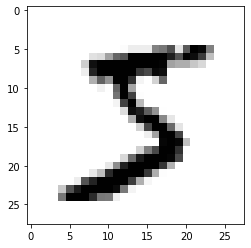

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = x[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.show()

In [8]:
y[0]

'5'

In [9]:
type(y[0])

str

The labels are strings. Most ML algorithms expect numbers, so cast all labels to ints

In [10]:
import numpy as np

y = y.astype(np.uint8)

In [11]:
type(y[0])

numpy.uint8

Next we split into training and test sets:

In [12]:
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

### Training a binary classifier (5 classifier)

We will simplify the problem initially by just trying to train a binary classifier that just detects whether a digit is or is not a 5. It will have two "classes", 5 and not-5. We can create a target vector that will contain true or false for whether the digit is a 5 or not. 

In [13]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

print(y_train[0], y_train_5[0])
print(y_train[1], y_train_5[1])

print(y_test[0], y_test_5[0])
print(y_test[8], y_test_5[8])

5 True
0 False
7 False
5 True


Now we pick a classifier and train it. We will start with stochastic gradient descent (SGD). This classifier is capable of handling very large datasets efficiently. 

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
print(y_train[0], y_train_5[0])
sgd_clf.predict([x_train[0]])

5 True


array([ True])

In [16]:
print(y_train[1], y_train_5[1])
sgd_clf.predict([x_train[1]])

0 False


array([False])

We can see that the classifier correctly predicted that the 0 was not a 5 and identified an actual 5. We will now evaluate the model's performance. We can use k-fold cross validation to do this. 
* k-fold cross-validation means splitting the training set into K folds then making predictions and evaluating them on each fold using a model trained on the remaining folds. This allows us to better utilize all the training data instead of splitting the training data into a train and validation set. 

In [17]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Looks like we got > 95% accuracy so this seems pretty good. Let's compare these results to a dumb classifier that just classifies everything as not-5. 

In [18]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, x, y=None):
        return self
    def predict(self, x):
        return np.zeros((len(x), 1), dtype=bool)

In [19]:
never_5_clf = Never5Classifier()

In [20]:
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

We see that this dumb classifier is still accurate about 90% of the time. This is because there are 10 unique digits with a relatively equal distribution, so only about 10% of the digits are fives. Accuracy is generally not a great performance measure for classifiers (especially when one class appears more frequently than others). 

A better way of evaluating performance of a classifier is a confusion matrix. Generally, you compute the number of times items were classified incorrectly. We can use `cross_val_predict()` to perform k-fold validation. It returns the prediction made for each instance in the test set by a model that has never seen that instance before (due to the folding). This way we get a clean prediction for each value in the test set. 

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an *actual class*, while each column represents a *predicted class*. The first row of the matrix considers non-5 images (the negative class). 53892 were correctly classified as non-5s (true negatives). 687 were wrongly classified as 5s (false positives). The second row considers images of 5s (positive class). 1891 were incorrectly classified as non-5s when they were 5s (false negatives). 3530 things were correctly classified as 5s (true positives). A perfect classifier would have only zeros except on the main diagonal. 

\begin{Bmatrix}
TN & FP \\
FN & TP 
\end{Bmatrix}

Perfect classifier example:

In [23]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

Precision: the accuracy of the positive predictions. True positives divided by true positives plus false positives. 

$$
precision = \frac{TP}{TP+FP}
$$

In [24]:
3530/(3530+687)

0.8370879772350012

Recall: ratio of positive instances that are correctly detected by the classifier. Also called sensitivity or true positive rate. 

$$
recall=\frac{TP}{TP+FN}
$$

In [25]:
3530/(3530+1891)

0.6511713705958311

Or we can use scikit-learn functions to compute these:

In [26]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [27]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

When our classifier claims an image represents a 5, it is correct only 83.7% of the time (precision). It only detects 65.1% of the 5s it sees (recall).

We can also combine precision and recall into a single metrics called the $F_1$ score. It is often useful to have a single value to easily compare classifiers. $F_1$ is the harmonic mean of the precision and recall. The regular mean treats all values equally when finding the average. The harmonic mean gives much more weight to low values. So to have a high $F_1$ score, both precision and recall must by high. 

$$
F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}}=2*\frac{precision*recall}{precision+recall}=\frac{TP}{TP+\frac{FN+FP}{2}}
$$

The $F_1$ score favors classifiers with similar precision and recall. This is not always desired. For example, if your classifier is trying to detect videos safe for kids, you would prefer a classifier that may reject many good videos (low recall, many false negatives) but keeps only safe ones (high precision, few false positives). An opposite example would be a classifier to detect shoplifters in surveillance images. In this case, low precision might be okay (some false alarms for shoplifters when they have not been shoplifting, high false positives) but high recall desired (all shoplifters detected, few false negatives). 

You can not have high precision and recall at the same time. It is a trade-off. Increasing one decreases the other. You need to decide which is more important for your model. 

In [28]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

The SGDClassifier computes a score for each instance it is trying to predict based on a decision function. If that score is greater than a threshold, the instance is assigned to the positive class. If it is less than the threshold, it's assigned to the negative class. If we increase this threshold, we raise the bar for what is classified positively. Thus we will have higher precision. However, this will cause us to miss some values that are actually in the positive class, so lower recall. If we lower the threshold, we will correctly classify more things (higher recall) but more false positives will slip in (lower precision). 

We can't set this threshold directly with scikit-learn but we can see the decision scores for each prediction made. We can then use any threshold we want to make predictions. SGDClassifier uses a threshold of zero. 

In [29]:
y_score = sgd_clf.decision_function([x_train[0]])
y_score

array([2164.22030239])

How do we decide what threshold to use? Use `cross_val_predict` to get decision scores for all instances. Then use `precision_recall_curve` to compute precision and recall for all possible thresholds. Then we can plot this to see the ideal value. 

In [30]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method='decision_function')

In [31]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

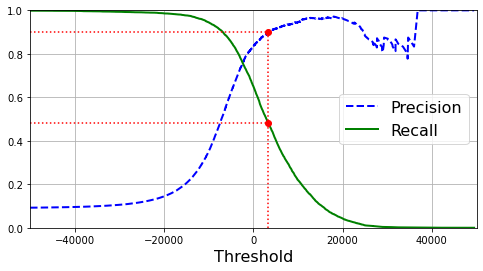

In [32]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, x_min, x_max):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([x_min, x_max, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, -50000, 50000)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

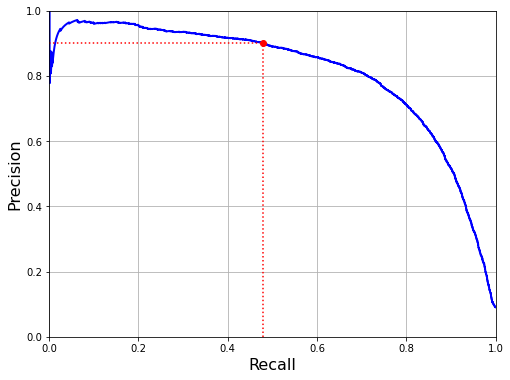

In [33]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In this graph we can see that precision starts to fall sharply around 80% recall, so we probably want to pick a lower target value, perhaps 60% recall. This will depend on context. 

We can choose a threshold to give us any precision we want. If we look at the first plot, we can see that a threshold of about 8,000 will give us 90% precision, with the trade-off of around 50% recall. We can compute the exact value to give us our desired precision and make predictions. But is this useful?

In [34]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [35]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

An alternative tool used to evaluate binary classifiers is the receiver operating characteristic (ROC) curve. This plots the true positive rate (recall) vs false positive rate (the ratio of negative instances are are incorrectly classified as positive). `FPR = 1 - TNR`. TNR = true negative rate (ratio of negative instances are are correctly classified as negative. TNR = specificity. 

`ROC = recall vs 1 - specificity`

In [36]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

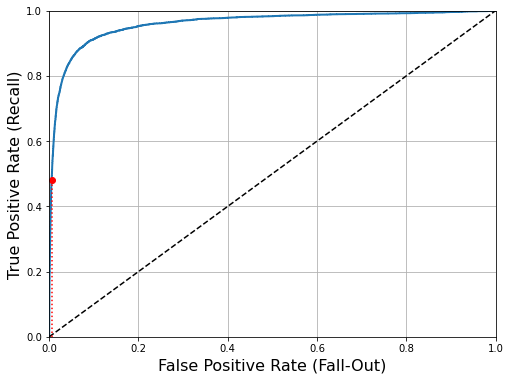

In [37]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()

We can compute the area under the curve (AUC) for the ROC curve. A perfect classifier will have a ROC AUC equal to 1 and a purely random classifier will have a score of 0.5. We want to be as close to 1 as possible. 

In [38]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Should we use P/R curve or ROC curve to evaluate binary classifiers?

* Prefer P/R curve when the positive class is rare or when you care more about false positives than false negatives
* Otherwise, use ROC curve

Looking at previous graph you'd think the classifier is really good but this is mostly because there are few positives (acutal 5s, only ~10% of training set) compared to negatives (non-5s). 

The PR curve makes it clear the classifier has room for improvement (could be closer to upper right corner). 

Now we will use a RandomForestClassifier and compare the results to the SGDClassifier. Random forest doesn't have a `decision_function()` method, it has `predict_proba()` instead. This returns an array with a value for each instance of the probability that the instances belongs to a given class (i.e. 70% change the image represents a 5). First column will contain negative class probability, 2nd column will be positive class probability. 

In [39]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method='predict_proba')

The `roc_curve()` function expects labels and scores but you can also give it probabilities instead of scores. We will use the positive class's probability as the score.

In [40]:
y_probas_forest[0] # 11% chance the first instance belongs to the negative class, 89% change positive class

array([0.11, 0.89])

In [41]:
y_scores_forest = y_probas_forest[:,1] # just take positive probability column
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

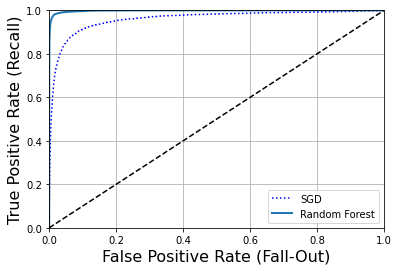

In [42]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [43]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [44]:
y_train_pred_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3)

In [45]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

In [46]:
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [47]:
precisions_forest, recalls_forest, pr_thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

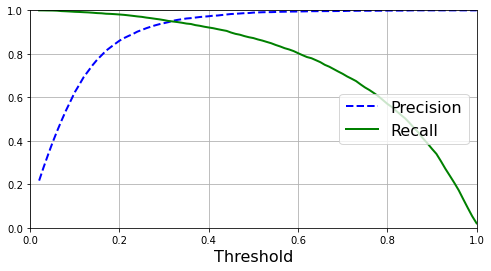

In [48]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions_forest, recalls_forest, pr_thresholds_forest, 0, 1)                          # Not shown
plt.show()

## Multiclass Classification

Some algorithms can handle multiple classes natively:
* Logistic Regression classifiers
* Random Forest classifiers
* Naive Bayes classifiers

Others are strictly binary classifiers:
* SGD classifiers
* Support Vector Machine classifiers

We can employ techniques to make binary classifiers work for multiple classes. One vs rest (OvR) where we train N classifiers, one for each class. Each classifier tests to see whether the instance is a member of that class or not. We use the decision score of each classifier and the highest decision score wins. 

Another technique is One vs One (OvO). With this you train $Nx(N-1)/2$ classifiers. You have one classifier to compare every possible combination of classes (1vs2 classifier, 1vs3, 1vs4, etc). 45 classifiers for 10 classes. You run instance thru all classifiers and see which class wins the most comparisons. Main advantage of this is that each classifier only needs to be trained on a subset of the training data (the two classes being compared). Some algos like Support Vector scale poorly with side of training set, so it is faster to train many classifiers with small datasets vs few classifiers with large training sets. 

For most algos, OvR is preferred. 

Scikit-learn detects when you try to use a binary classification algorithm for a multiclass classification task and automatically runs OvR or OvO depending on the algo.  

In [49]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(x_train, y_train)

SVC()

In [50]:
svm_clf.predict([x_train[0]])

array([5], dtype=uint8)

This actually trains 45 binary support vector classifiers using OvO strategy and makes a prediction based on decision scores from each classifier. Calling `decision_function()` you will get 10 scores per instance. These are the number of won duels +/- a small tweak to break ties. 

In [51]:
svm_clf.decision_function([x_train[0]])

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [52]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Note that when a classifier is trained, it stores an array of classes in its `classes_` attribute. In our case, the indices correspond to the classes but this will not always be the case.

We can force use OvO or OvR strategy by using `OneVsOneClassifier` or `OneVsRestClassifier` classes. Create an instance and pass the classifier in the constructor. It doesn't need to be a binary classifier. 

In [53]:
# takes forever
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(x_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [54]:
ovr_clf.predict([x_train[0]])

array([5], dtype=uint8)

In [55]:
ovr_clf.estimators_

[SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC()]

We can similarly train an SGDClassifier:

In [56]:
sgd_clf.fit(x_train, y_train) # using OvR under the hood

SGDClassifier(random_state=42)

In [57]:
sgd_clf.decision_function([x_train[0]]) # now returns one value per class, mostly all neg except 5 class

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

Now we want to evaluate the classifier. We can use cross-validation for this. A random classifier would now give us 10% accuracy since there are 10 classes. We could improve accuracy further by scaling the inputs, since currently each pixel is represented by 0-255. 

In [58]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [59]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

TODO: now that we have a better understanding of classifiers, we should explore data preparation options, try out multiple models (shortlisting the best ones and tuning their hyperparameters using GridSearchCV) and automate as much of the process as possible for when we evaluate on our test set. 

### Error Analysis

To start, we want to look at the types of errors our model is making. We can look at the confusion matrix for this. 

In [60]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)

In [61]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

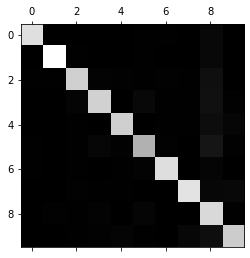

In [62]:
plt.matshow(conf_mx, cmap=plt.cm.gray) # plot confusion matrix
plt.show()

This isn't very useful, everything just looks black for the most part. We want to focus in on the errors. We can divide each value in the confusion matrix by the number of images in the corresponding class to compare error rates instead of absolute numbers. 

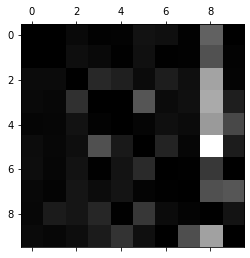

In [63]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0) # fill diagional with zeros so we can just look at error rate
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Now we can see the types of errors the classifier is making. The darker the square the better. Rows represent actual classes and columns represent predicted classes. We can see here that in the 8 column, there are a lot of light squares. This means that a lot of things are being incorrectly predicted to be 8s. But the 8 row is pretty dark, so 8s are being correctly classified. We can also tell that there is come confusion between 3s and 5s. If we look at row 3,5, the square is light. this means that 3s are being predicted as 5s. We can see the same type of error in 5,3 where 5s are being classified incorrectly as 3s. 

We should focus our efforts on reducing these types of errors. We could try to get more data for these classes, engineer new features such as an algorithm that counts the number of closed loops (8 has 2, 6 has 1 and 5 has 0) or pre-process the images using something like scikit-image, pillow or openCV to make certain patterns stand out more. 

Another way to analyze error is to look at individual errors. 

In [64]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [65]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

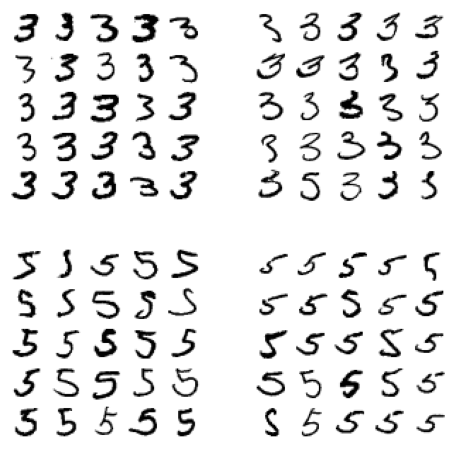

In [66]:
cl_a, cl_b = 3, 5
X_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

This is a confusion matrix for the 3s and 5s. On the diagonal are correct predictions. The other two boxes are incorrect classifications. We can see that some of our input data isn't great and would be hard for even a human to distinguish, but most look pretty obvious. 

Some of the confusion can be explained by the type of model we used (SGDClassifier). This is a linear model that assigns a weight to each pixel. When it sees a new image, it sums up all the weights to get a score for each class. Since 3s and 5s differ by only a few pixels the model will easily confuse them. We should explore different model options. 

### Multillabel Classification

This is classification in which instances can be assigned to multiple classes. An example might be a facial detection classifier. There might be several people in the same picture and we want to be able to tell if a specific person is or is not in a picture. We train the model to recognize 3 faces, Alice, Bob and Carol and we want it to output a true/false if the person is in the picture or not. Note that this is outputting multiple binary classifications. 

We can do a simple example of this on our data. Below we want to determine whether a number is >= 7 and whether it is odd. 

Note: KNeighborsClassifier supports multilabel classification but not all algos do. 

In [67]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = y_train >= 7
y_train_odd = y_train %2 == 1
y_multilabel = np.c_[y_train_large, y_train_odd]

In [68]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier()

In [69]:
knn_clf.predict([x_train[0]]) # predicts the 5 is not less than 7 and that it is odd

array([[False,  True]])

One way to evaluate a multilabel classifier is the measure the $F_1$ score of each label and then compute the average. However, the best metric will depend on context. 

Below code assumes all labels are equally important but this may not be true. There may be more examples of odd numbers than large numbers and we may want to give more weight to that label when computing the $F_1$. We can use `average=weighted` for this. 

In [70]:
# takes a long time
y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_multilabel, cv=3)

In [71]:
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

In [72]:
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

0.9778357403921755

### Multioutput classification

This is similar to multilabel classification discussed previously but instead of multiple binary labels, each label can have multiple classes. 

An example would be a system that removes noise from images of digits like the MNIST digits. The images will be represented as an array of pixel intensities just like MNIST. The classifier's output is multi-label because it will have one label per pixel and each label can have multiple values (pixel intensity 0-255). 

Note: line between classification and regression gets blurry here. 

We will test this out by adding some noise to images and then building a model to try to remove the noise. 

In [73]:
# generates random int 0-100, one row for each instance in trainig set and one col for each pixel
noise = np.random.randint(0, 100, (len(x_train), 784)) 
x_train_mod = x_train + noise # add the noise 
noise = np.random.randint(0, 100, (len(x_test), 784))
x_test_mod = x_test + noise # in real project don't use test set like this
y_train_mod = x_train # desired output is our x training data without the noise
y_test_mod = x_test

We can see an example of a digit with noise added and the corresponding target image (the original image before noise was added). 

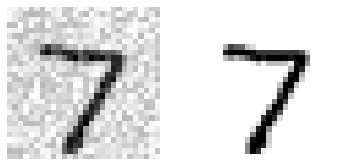

In [74]:
plt.subplot(121); plot_digit(x_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
plt.show()

In [75]:
knn_clf.fit(x_train_mod, y_train_mod)

KNeighborsClassifier()

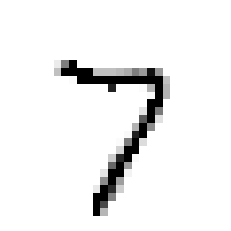

In [76]:
clean_digit = knn_clf.predict([x_test_mod[0]])
plot_digit(clean_digit) # output of image cleaned by model

### Exercises

1. Build a classifier for MNIST dataset that achieves over 97% accuracy on the test set. 